# Basic usage for `ldpc_post_selection` package

In [2]:
import stim
import numpy as np

## Global strategy

In [3]:
# Example circuit
from ldpc_post_selection.stim_tools import remove_detectors_from_circuit

circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=9,
    distance=9,
    after_clifford_depolarization=0.005,
    before_measure_flip_probability=0.005,
    after_reset_flip_probability=0.005,
)

# Use only Z-type detectors for evaluating confidence

detector_coords = circuit.get_detector_coordinates()
det_ids_to_remove = []  # X-type detectors
for det_id, (x, y, z) in detector_coords.items():
    if (round(x) + round(y)) % 4 == 2:
        det_ids_to_remove.append(det_id)
circuit = remove_detectors_from_circuit(circuit, det_ids_to_remove)

In [4]:
# Defining the soft-output BP+LSD decoder
from ldpc_post_selection.decoder import SoftOutputsBpLsdDecoder

bplsd = SoftOutputsBpLsdDecoder(
    circuit=circuit,
    max_iter=30,
    bp_method="minimum_sum",
    lsd_method="LSD_0",
    lsd_order=0,
    ms_scaling_factor=1.0,
)

### Example: Single sample

In [5]:
# Create a single sample
sampler = circuit.compile_detector_sampler(seed=42)
det, obs = sampler.sample(shots=1, separate_observables=True)

# Decode the sample and obtain soft outputs
correction, correction_bp, converge, soft_outputs = bplsd.decode(det[0])
obs_correction = correction @ bplsd.obs_matrix.T % 2
success = np.all(obs[0] == obs_correction)

from pprint import pprint

print("Correction:", correction)
print("Correction from BP (valid only when BP converges):", correction_bp)
print("Whether BP converges:", converge)
print("Decoding success:", success)
print()
print("Soft outputs:")
pprint(soft_outputs)

Correction: [False False False ... False False False]
Correction from BP (valid only when BP converges): [False False False ... False False False]
Whether BP converges: True
Decoding success: True

Soft outputs:
{'cluster_llrs': array([1.00665782e+04, 4.36430835e+00, 5.92425580e+00, 4.53799718e+00,
       4.17360043e+00, 5.05741505e+00, 4.17360043e+00, 4.53799718e+00,
       4.17360043e+00, 4.17360043e+00, 5.23111577e+00]),
 'cluster_sizes': array([1935,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1]),
 'clusters': array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
 'detector_density': np.float64(0.05),
 'pred_llr': 46.34749104768056}


**Soft outputs:**

- `'cluster_sizes'`: Cluster sizes (first element: outside clusters)
- `'cluster_llrs'`: LLR sums within each cluster (first element: outside clusters)
- `'clusters'`: Cluster assignment for each error mechanism (0: outside clusters, `i>0`: `i`-th cluster)
- `'detector_density'`: Number of violated detectors divided by the total number of detectors
- `'pred_llr'`: LLR weight of the correction

In [6]:
# Computing cluster size/LLR norm fractions

from ldpc_post_selection.cluster_tools import compute_cluster_norm_fraction

size_norm_frac = compute_cluster_norm_fraction(soft_outputs["cluster_sizes"], 2)
llr_norm_frac = compute_cluster_norm_fraction(soft_outputs["cluster_llrs"], 2)
print("Cluster size 2-norm fraction =", size_norm_frac)
print("Cluster LLR 2-norm fraction =", llr_norm_frac)

size_norm_frac = compute_cluster_norm_fraction(soft_outputs["cluster_sizes"], np.inf)
llr_norm_frac = compute_cluster_norm_fraction(soft_outputs["cluster_llrs"], np.inf)
print("Cluster size infinity-norm fraction =", size_norm_frac)
print("Cluster LLR infinity-norm fraction =", llr_norm_frac)

Cluster size 2-norm fraction = 0.0016258496967446682
Cluster LLR 2-norm fraction = 0.0014598231241090044
Cluster size infinity-norm fraction = 0.0005141388174807198
Cluster LLR infinity-norm fraction = 0.0005858102776987654


### Example: Batch simulation

In [7]:
from tqdm import tqdm

shots = 100000

sampler = circuit.compile_detector_sampler(seed=42)
det, obs = sampler.sample(shots=shots, separate_observables=True)

fails = []
norm_fracs = []

for i_sample in tqdm(list(range(shots))):
    correction, _, _, soft_outputs = bplsd.decode(det[i_sample])
    obs_correction = correction @ bplsd.obs_matrix.T % 2
    fail = np.any(obs[i_sample] != obs_correction)
    norm_frac = compute_cluster_norm_fraction(soft_outputs["cluster_llrs"], 2)
    fails.append(fail)
    norm_fracs.append(norm_frac)

100%|██████████| 100000/100000 [00:54<00:00, 1824.02it/s]


In [8]:
# Calculating failure rates for different cutoffs

from statsmodels.stats.proportion import proportion_confint

fails_array = np.array(fails)
norm_fracs_array = np.array(norm_fracs)
cutoffs = np.logspace(np.log10(min(norm_fracs)), np.log10(max(norm_fracs)), 100)

mask = norm_fracs_array[np.newaxis, :] <= cutoffs[:, np.newaxis]
num_accepted = mask.sum(axis=1)
num_failures = (mask * fails_array[np.newaxis, :]).sum(axis=1)

failure_rates = num_failures / num_accepted
abort_rates = 1 - num_accepted / shots

# Calculate 95% confidence intervals using Wilson score interval
confidence_level = 0.95

# Failure rate confidence intervals
failure_rate_lower, failure_rate_upper = proportion_confint(
    num_failures, num_accepted, alpha=1 - confidence_level, method="wilson"
)

# Abort rate confidence intervals (based on selection rate)
# Calculate CI for selection rate, then convert to abort rate
selection_rate_lower, selection_rate_upper = proportion_confint(
    num_accepted, shots, alpha=1 - confidence_level, method="wilson"
)

# Abort rate is 1 - selection rate, so we flip the bounds
abort_rate_lower = 1 - selection_rate_upper
abort_rate_upper = 1 - selection_rate_lower

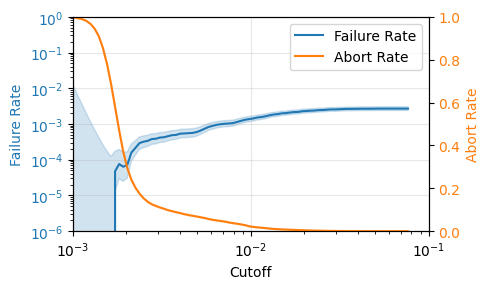

In [9]:
# Plotting failure and abort rates vs cutoffs

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot failure rate on left y-axis
color1 = "tab:blue"
ax1.set_xlabel("Cutoff")
ax1.set_ylabel("Failure Rate", color=color1)
ax1.plot(cutoffs, failure_rates, color=color1, label="Failure Rate")
ax1.fill_between(
    cutoffs, failure_rate_lower, failure_rate_upper, color=color1, alpha=0.2
)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Create second y-axis for abort rate
ax2 = ax1.twinx()
color2 = "tab:orange"
ax2.set_ylabel("Abort Rate", color=color2)
ax2.plot(cutoffs, abort_rates, color=color2, label="Abort Rate")
ax2.fill_between(cutoffs, abort_rate_lower, abort_rate_upper, color=color2, alpha=0.2)
ax2.tick_params(axis="y", labelcolor=color2)

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

ax1.set_xscale("log")
ax1.set_yscale("log")

ax1.set_xlim(1e-3, 1e-1)
ax1.set_ylim(1e-6, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Real-time strategy

In [10]:
# Example circuit
from ldpc_post_selection.stim_tools import remove_detectors_from_circuit

distance = 9
total_rounds = 9

circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=total_rounds,
    distance=distance,
    after_clifford_depolarization=0.005,
    before_measure_flip_probability=0.005,
    after_reset_flip_probability=0.005,
)

# Use only Z-type detectors for evaluating confidence
detector_coords = circuit.get_detector_coordinates()
det_ids_to_remove = []  # X-type detectors
for det_id, (x, y, z) in detector_coords.items():
    if (round(x) + round(y)) % 4 == 2:
        det_ids_to_remove.append(det_id)
circuit = remove_detectors_from_circuit(circuit, det_ids_to_remove)

In [11]:
# Defining the decoder
from ldpc_post_selection.decoder import SoftOutputsBpLsdDecoder

bplsd = SoftOutputsBpLsdDecoder(
    circuit=circuit,
    max_iter=30,
    bp_method="minimum_sum",
    lsd_method="LSD_0",
    lsd_order=0,
    ms_scaling_factor=1.0,
    detector_time_coords=-1,
)

*Note:* The `detector_time_coords` parameter (default `-1`) determines the time coordinates of detectors, which is necessary for sliding-window decoding (SWD). If an integer `i` is given, the `i`-th coordinate of each detector annotated in the stim circuit is treated as its time coordinate. If a sequence of integers is given, it directly specifies the time coordinates. The time coordinates **must** start from 0; otherwise, an error is raised.

### Example: Single sample

In [12]:
sampler = circuit.compile_detector_sampler(seed=42)
det, obs = sampler.sample(shots=1, separate_observables=True)

window_size = 3
commit_size = 1

correction, soft_outputs = bplsd.decode_sliding_window(
    det[0], window_size=window_size, commit_size=commit_size
)
obs_correction = correction @ bplsd.obs_matrix.T % 2
success = np.all(obs[0] == obs_correction)

from pprint import pprint

print("Correction:", correction)
print("Decoding success:", success)
print()
print("Soft outputs:")
pprint(soft_outputs)

Correction: [False False False ... False False False]
Decoding success: True

Soft outputs:
{'all_clusters': [array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
                  array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
                  array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
                  array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
                  array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
                  array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
                  array([0, 0, 0, ..., 0, 0, 0], shape=(1945,)),
                  array([0, 0, 0, ..., 0, 0, 0], shape=(1945,))],
 'committed_clusters': [array([False, False, False, ..., False, False, False], shape=(1945,)),
                        array([False, False, False, ..., False, False, False], shape=(1945,)),
                        array([False, False, False, ..., False, False, False], shape=(1945,)),
                        array([False, False, False, ..., False, False, False], shape=(1945,)),
       

**Soft outputs:**

All the values of the dictionary are lists of arrays, where each element is obtained from decoding a window. Namely, the length of each list is equal to the number of windows.

- `all_clusters[i]` (integer array): Cluster assignment obtained from decoding the `i`-th window.
- `committed_clusters[i]` (boolean array): Specifies whether each error mechanism belongs to a cluster AND is committed from the `i`-th window.
- `committed_faults[i]` (boolean array): Specifies whether each error mechanism is committed from the `i`-th window. (This is determined by the circuit and the parameters of SWD, independent of the sample, and thus it is strictly not a soft output of decoding. However, we include this in the dictionary for convenience.)

In [13]:
# Computing commited cluster norm fractions

from ldpc_post_selection.sliding_window_tools import CommittedClusterNormCalculator

# A calculator instance with pre-computed information
# Can be efficiently reused for multiple samples or metric parameters
committed_cluster_norm_calculator = CommittedClusterNormCalculator(
    committed_faults=soft_outputs["committed_faults"],
    priors=bplsd.priors,
    H=bplsd.H,
)

# Computing the committed cluster norm fraction for a sample
# for a given norm order, value type, and lookback window size
norm_order = 2
value_type = "llr"  # 'llr' or 'size'
lookback_window_size = 3
norm_fracs = committed_cluster_norm_calculator.compute(
    committed_clusters=soft_outputs["committed_clusters"],
    norm_order=norm_order,
    value_type=value_type,
    lookback_window_size=lookback_window_size,
)

print(
    f"Committed cluster {value_type.upper()} {norm_order}-norm fractions for each evaluation region:"
)
for i, norm_frac in enumerate(norm_fracs):
    i_window = i + lookback_window_size - 1
    i_round = i_window * commit_size + window_size - 1
    round_text = (
        f"round {i_round}" if i_round < total_rounds else "data qubit measurement"
    )
    print(f"  After window {i_window} ({round_text}): {norm_frac}")
print("  (Window and round indices start from 0.)")

Committed cluster LLR 2-norm fractions for each evaluation region:
  After window 2 (round 4): 0.00267203324593658
  After window 3 (round 5): 0.0026186116409883534
  After window 4 (round 6): 0.0022801462841924997
  After window 5 (round 7): 0.0018076362689302106
  After window 6 (round 8): 0.0022801462841924997
  After window 7 (data qubit measurement): 0.002214614056924642
  (Window and round indices start from 0.)


### Example: Batch simulation

In [14]:
# Sampling & decoding

from tqdm import tqdm

shots = 10000
window_size = 3
commit_size = 1

sampler = circuit.compile_detector_sampler(seed=42)
det, obs = sampler.sample(shots=shots, separate_observables=True)

fails = []
committed_clusters = []
committed_faults = None

for i_sample in tqdm(list(range(shots))):
    correction, soft_outputs = bplsd.decode_sliding_window(
        det[i_sample], window_size=window_size, commit_size=commit_size
    )
    obs_correction = correction @ bplsd.obs_matrix.T % 2
    fail = np.any(obs[i_sample] != obs_correction)
    fails.append(fail)
    committed_clusters.append(soft_outputs["committed_clusters"])
    if committed_faults is None:
        committed_faults = soft_outputs["committed_faults"]

fails = np.array(fails)

100%|██████████| 10000/10000 [00:23<00:00, 433.97it/s]


In [15]:
# Calculating committed cluster norm fractions

norm_order = 2
value_type = "llr"  # 'llr' or 'size'
lookback_window_size = 3

committed_cluster_norm_calculator = CommittedClusterNormCalculator(
    committed_faults=committed_faults,
    priors=bplsd.priors,
    H=bplsd.H,
)

norm_fracs = []
for i_sample in tqdm(list(range(shots))):
    norm_fracs_sample = committed_cluster_norm_calculator.compute(
        committed_clusters=committed_clusters[i_sample],
        norm_order=norm_order,
        value_type=value_type,
        lookback_window_size=lookback_window_size,
    )
    norm_fracs.append(norm_fracs_sample)
norm_fracs = np.vstack(norm_fracs)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 7582.91it/s]


In [16]:
window_indices = np.arange(norm_fracs.shape[1]) + lookback_window_size - 1
round_indices = window_indices * commit_size + window_size - 1
round_indices = np.minimum(round_indices, total_rounds - 1)

# Round indice for each evaluation region (row of norm_fracs)
# The final data qubit measurement is treated to be included in the last round.
round_indices

array([4, 5, 6, 7, 8, 8])

In [17]:
# Computing the aborted round indices (or -1 if accepted) for each sample and cutoff

# Cutoff values
max_norm_frac_for_each_sample = norm_fracs.max(axis=1)
norm_frac_min = np.min(max_norm_frac_for_each_sample)
norm_frac_max = np.max(max_norm_frac_for_each_sample)
cutoffs = np.logspace(np.log10(norm_frac_min), np.log10(norm_frac_max), 101)[1:]

# Find the smallest round index where norm_frac >= cutoff for each sample and cutoff
num_samples = norm_fracs.shape[0]
num_cutoffs = len(cutoffs)

# Shape: (num_samples, num_windows, num_cutoffs)
exceeds_cutoff = norm_fracs[:, :, np.newaxis] >= cutoffs[np.newaxis, np.newaxis, :]

# Initialize aborted_rounds with -1 (accepted)
aborted_rounds = np.full((num_samples, num_cutoffs), -1, dtype=int)

# For each sample and cutoff, find the first window where condition is met
for i_sample in range(num_samples):
    for i_cutoff in range(num_cutoffs):
        # Find first window index where norm_frac >= cutoff
        window_idx = np.argmax(exceeds_cutoff[i_sample, :, i_cutoff])
        # Check if condition is actually met (argmax returns 0 even if all False)
        if exceeds_cutoff[i_sample, window_idx, i_cutoff]:
            aborted_rounds[i_sample, i_cutoff] = round_indices[window_idx]

In [18]:
# Calculating failure rates and average time costs per accepted shot

from statsmodels.stats.proportion import proportion_confint

accepted = aborted_rounds == -1
last_rounds = np.where(accepted, round_indices[-1], aborted_rounds)

num_accepted = np.sum(accepted, axis=0)

avg_time_cost_per_accepted_shot = np.sum(last_rounds + 1, axis=0) / np.sum(
    accepted, axis=0
)

num_failures = np.sum(fails[:, np.newaxis] & accepted, axis=0)
num_accepted = np.sum(accepted, axis=0)
failure_rates = num_failures / num_accepted
failure_rate_lower, failure_rate_upper = proportion_confint(
    num_failures, num_accepted, alpha=0.05, method="wilson"
)

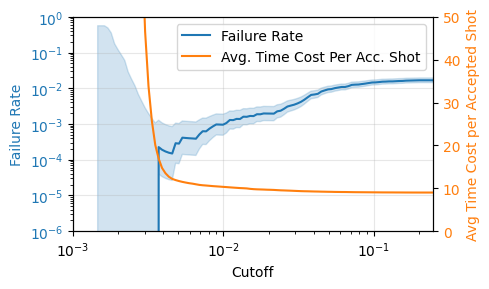

In [19]:
# Plotting failure rate and average time cost vs cutoffs

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot failure rate on left y-axis
color1 = "tab:blue"
ax1.set_xlabel("Cutoff")
ax1.set_ylabel("Failure Rate", color=color1)
ax1.plot(cutoffs, failure_rates, color=color1, label="Failure Rate")
ax1.fill_between(
    cutoffs, failure_rate_lower, failure_rate_upper, color=color1, alpha=0.2
)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Create second y-axis for average time cost
ax2 = ax1.twinx()
color2 = "tab:orange"
ax2.set_ylabel("Avg Time Cost per Accepted Shot", color=color2)
ax2.plot(
    cutoffs,
    avg_time_cost_per_accepted_shot,
    color=color2,
    label="Avg. Time Cost Per Acc. Shot",
)
ax2.tick_params(axis="y", labelcolor=color2)

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

ax1.set_xscale("log")
ax1.set_yscale("log")

ax1.set_xlim(1e-3, max(cutoffs))
ax1.set_ylim(1e-6, 1)
ax2.set_ylim(0, 50)

plt.tight_layout()
plt.show()